# Visualization + Results for Linear Regression
## Model Setup/description

We trained a linear regression model to predict the E/P ratio of firms using a small subset of accounting and financial performance variables taken from the Compustat database on WRDS. The dataset was divided into training and testing sets, and a simple linear regression model was fitted.

For this model, we only used four firm-level features: \
ROE (Return on Equity), ROA (Return on Assets), Debt-to-Equity Ratio, and Sales Growth.

The goal of this baseline model is to establish how well a linear relationship among these four variables can explain the observed variation in firm's E/P ratios before we move on to include more/different features or try out nonlinear methods.

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
# Load processed data
train_data = pd.read_parquet('../data/processed/train.parquet')
test_data = pd.read_parquet('../data/processed/test.parquet')

features = ['roe', 'roa', 'debt_to_eq', 'sales_growth']
target = 'ep'

X_train = train_data[features]
Y_train = train_data[target]
X_test = test_data[features]
Y_test = test_data[target]

# Train the model (or use existing trained model)
model = LinearRegression()
model.fit(X_train, Y_train)

# Predictions
Y_pred_train = model.predict(X_train)
Y_pred_test = model.predict(X_test)
print("DONE")


DONE


## Scatterplot of predicted vs actual E/P values

The following plot compares actual E/P values (x-axis) with model-predicted E/P values (y-axis). If the model were perfectly accurate, all points would lie exactly on the red dashed diagonal line (the line of perfect prediction where predicted value == actual value).

### Observations:
- Both axes range from approximately –5 to 0.

- Majority of datapoints are clustered near the horizontal center of the graph, around predicted values close to zero. This indicates that the model tends to output predictions near the mean E/P value (near 0 for most observations) regardless of the true E/P, reflecting a bias toward average outcomes. Only a small number of points lie close to the red line, suggesting limited predictive accuracy.

- Failure to capture extremes: Many firms have negative actual E/P values (some as low as –5). However, the model does not reproduce these extreme cases, it predicts values that remain close to zero even for firms with large losses. This indicates that the linear model underestimates the magnitude of negative earnings yields. It also leads to a broad vertical dispersion of points, especially for companies with strongly negative actual E/P ratios. The result is a cloud-like pattern rather than a tight diagonal alignment.

### Possible causes:

- Relationship between fundamentals and valuation (E/P) might be nonlinear, which a simple linear regression cannot capture.

- The small feature set might omit many factors that influence valuation, such as market conditions, industry effects, and expectations of future earnings.

- Noise and reporting variability in accounting data might further limit predictive accuracy.

### Interpretation/implications:

- Model underfitting: near-vertical concentration of points suggests that the linear regression model is underfitting and does not capture much variability in the target. The four chosen features are not able to fully explain the observed variation in E/P which is consistent with the low R^2 we encounter (discussed later).

- Weak predictive spread: since the model’s predictions remain close to zero, it effectively learns an average E/P level rather than differentiating across firms. This might be because the chosen features have weak or noisy relationships with E/P or that true underlying relationship is nonlinear. Outliers or skewed distributions in E/P can also distort the fitted coefficients.

- Asymmetric performance: The model performs particularly poorly for firms with large negative E/P values, suggesting it struggles with asymmetric or heavy-tailed financial data.

- Need for expanded feature engineering: The results indicate that additional variables such as profitability margins, valuation multiples, or size controls might be necessary to capture the differences in E/P. We might also need to explore nonlinear methods.

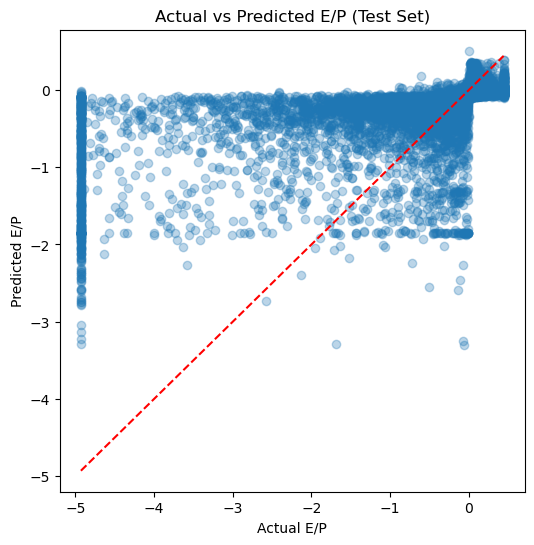

In [3]:
plt.figure(figsize=(6,6))
plt.scatter(Y_test, Y_pred_test, alpha=0.3)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--')  
plt.xlabel("Actual E/P")
plt.ylabel("Predicted E/P")
plt.title("Actual vs Predicted E/P (Test Set)")
plt.show()


## Residuals vs Predicted E/P

The residual plot visualizes the relationship between the model’s predicted E/P values and the corresponding residuals (actual minus predicted). Ideally, residuals should be randomly scattered around zero with no discernible pattern, indicating that the model’s errors are evenly distributed and that the linear assumptions hold.

### Observations:
- Triangular spread: the residuals form a triangular pattern, being widely dispersed for more negative predicted E/P values and tightly clustered near zero as predictions approach zero. This indicates heteroscedasticity, which means that the model’s error variance increases as the predicted value becomes more extreme. In other words, the model performs relatively consistently for firms with typical or near-zero E/P ratios but becomes increasingly unreliable for firms with large negative earnings yields.

- Systematic underestimation of negative E/P values: the visible diagonal cluster of points in the lower-left region (extending from approximately (–2.75, –2) to (0, –4.5)) suggests a systematic bias. For firms with strongly negative actual E/P values, the model tends to underpredict the magnitude of the losses, yielding large negative residuals. This pattern reinforces the results from the previous plot: the linear model is unable to capture the nonlinear dynamics that drive extremely low valuations.

- Dense concentration around (0, 0): near the center of the plot, residuals are tightly clustered around zero, implying that the model performs moderately well for the bulk of the data, companies with stable or near-zero E/P ratios. 

- Lack of symmetry and randomness: the residuals are not symmetrically distributed around the zero line, nor do they appear random. Instead, clear structural patterns are present. This violates a key assumption of linear regression - that residuals are independent, identically distributed, and centered around zero - which further suggests that the linear model is inadequate.

### Implications/Next steps:

The linear model systematically underestimates firms with extreme negative valuations. The presence of heteroscedasticity means that the variance of errors depends on the scale of the predicted E/P, which linear regression does not handle well. The model likely misses nonlinear relationships or interaction effects among financial ratios. To improve, we can take the following steps:

- Introduce nonlinear or composite features to help capture more complex relationships.
- Experiment with tree-based models such as Random Forests, Gradient Boosting, or nonlinear regressors (SVR) that can model curvature and variable interactions automatically.
- We could attempt to model residuals separately or apply techniques like weighted least squares to address heteroscedasticity that is present.
- We could also try to evaluate the model separately for profitable vs unprofitable firms, as the E/P relationship may differ fundamentally between these groups.

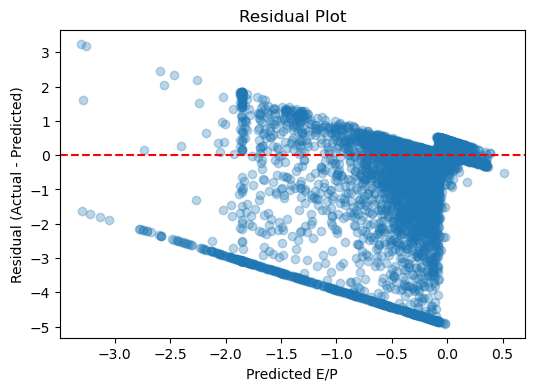

In [4]:
residuals = Y_test - Y_pred_test

plt.figure(figsize=(6,4))
plt.scatter(Y_pred_test, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted E/P")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot")
plt.show()


## Feature coefficient chart
The bar chart of linear regression coefficients gives insight into the direction and relative importance of each predictor variable in explaining variation in the E/P ratio. In this model, the coefficients represent the expected change in E/P for a one-unit standardized increase (one std deviation) in each feature, holding all other features constant.

### Observations:
- ROA (≈ 0.22):
ROA has the largest positive coefficient among all features, indicating that it has the strongest influence on the model’s predicted E/P values. This suggests that firms generating higher earnings relative to total assets tend to have higher E/P ratios, which makes sense intuitively: more efficient asset utilization generally signals profitability and stability.

- ROE (≈ 0.187)
ROE also contributes positively to predicted E/P, reflecting that companies earning higher returns on shareholders’ equity are typically valued more favorably. The slightly smaller coefficient compared to ROA could imply that ROA captures a broader and more consistent signal than ROE, which can be more volatile.

- Debt-to-Equity Ratio (≈ 0.037)
The positive but relatively small coefficient indicates a weak direct relationship between leverage and E/P ratio in this dataset. A modest positive value might suggest that, within certain bounds, higher Debt-to-Equity is associated with higher valuation yield. However, the low magnitude might suggest that the effect of this feature is complex and not strongly linear.

- Sales Growth (≈ 0.02)
Sales growth has the smallest coefficient, implying that recent growth in revenue has limited explanatory power for current E/P ratios in the sample.

### Implications and Next Steps:
The model’s predictions rely primarily on profitability indicators (ROA and ROE), while sales growth and debt-to-equity contribute marginally. This makes intuitive sense but also indicates that the model’s feature space is too narrow, it captures only a small slice of what drives company valuations. The low overall predictive power implies that even though these coefficients are interpretable, the linear relationships are too simple to explain complex valuation dynamics. Our next steps may include:

- Expand the feature set by incorporating additional accounting ratios.
- Explore feature interactions: nonlinear interactions between profitability, leverage, and growth might be critical.
- Try nonlinear models such as Random Forests, Gradient Boosting or Neural Networks can automatically learn nonlinear feature interactions that linear regression misses.
- When using tree-based methods, we can compute feature importance or SHAP values to understand which variables truly drive the predictions across different firms and conditions.

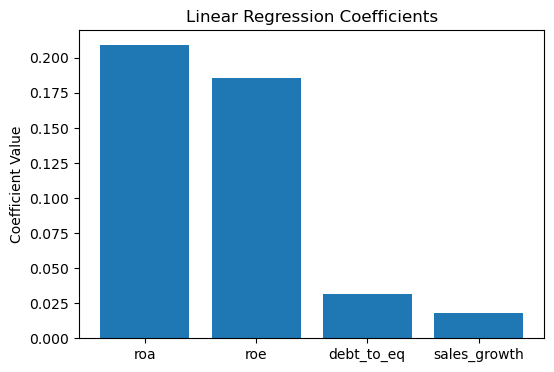

In [5]:
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(6,4))
plt.bar(coef_df['Feature'], coef_df['Coefficient'])
plt.title("Linear Regression Coefficients")
plt.ylabel("Coefficient Value")
plt.show()


## Residual Distribution Histogram

The histogram of residuals (prediction errors) shows how the model’s deviations from actual E/P values are distributed across the test set. Ideally, in a well-performing linear regression model, residuals should be centered around zero and roughly symmetrical, following a bell-shaped (normal) distribution. This would indicate that the model’s errors are unbiased and consistent across the dataset. In our case, it seems to show a non-normal and highly skewed pattern.

### Observations:

- Sharp peak near zero, exceeding 10,000 observations. This indicates that for a large number of companies, the model’s predictions are almost exactly equal to the actual E/P or only slightly off. This heavy central concentration means the model is effectively “collapsing” predictions toward a narrow range (around zero), producing many small residuals simply because it predicts near the overall mean for most firms.

- Long left tail or negative skew: as the histogram extends leftward, the residual frequency decreases gradually, meaning there are many cases where the actual E/P is much lower than the predicted value. This confirms that the model systematically underestimates companies with strongly negative E/P ratios. In other words, it fails to capture extreme losses.

- The right tail, in contrast, drops off sharply, showing that the model rarely overpredicts by large margins. This asymmetry indicates a directional bias: predictions are more likely to be too high (relative to the true value) than too low.

- Non-gaussian shape: distribution is not bell-shaped but rather spiked and skewed, suggesting that the residuals are not normally distributed. This violates one of the key assumptions of linear regression (normality of errors) and implies that the linear model’s functional form may not be appropriate for the underlying data.

### Implications and Next Steps:
The LR model is biased toward the mean, producing predictions centered around zero. The residuals show negative skewness, confirming that the model systematically underestimates extreme negative valuations. The assumption of normally distributed residuals does not hold  which is a sign that the relationship between financial ratios and valuation is nonlinear. Next steps:

- Feature expansion.
- Apply nonlinear models.

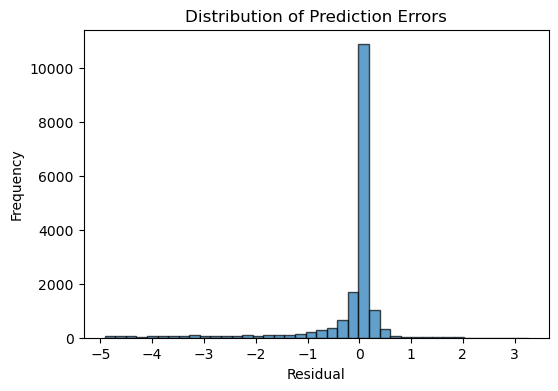

In [6]:
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=40, edgecolor='black', alpha=0.7)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()


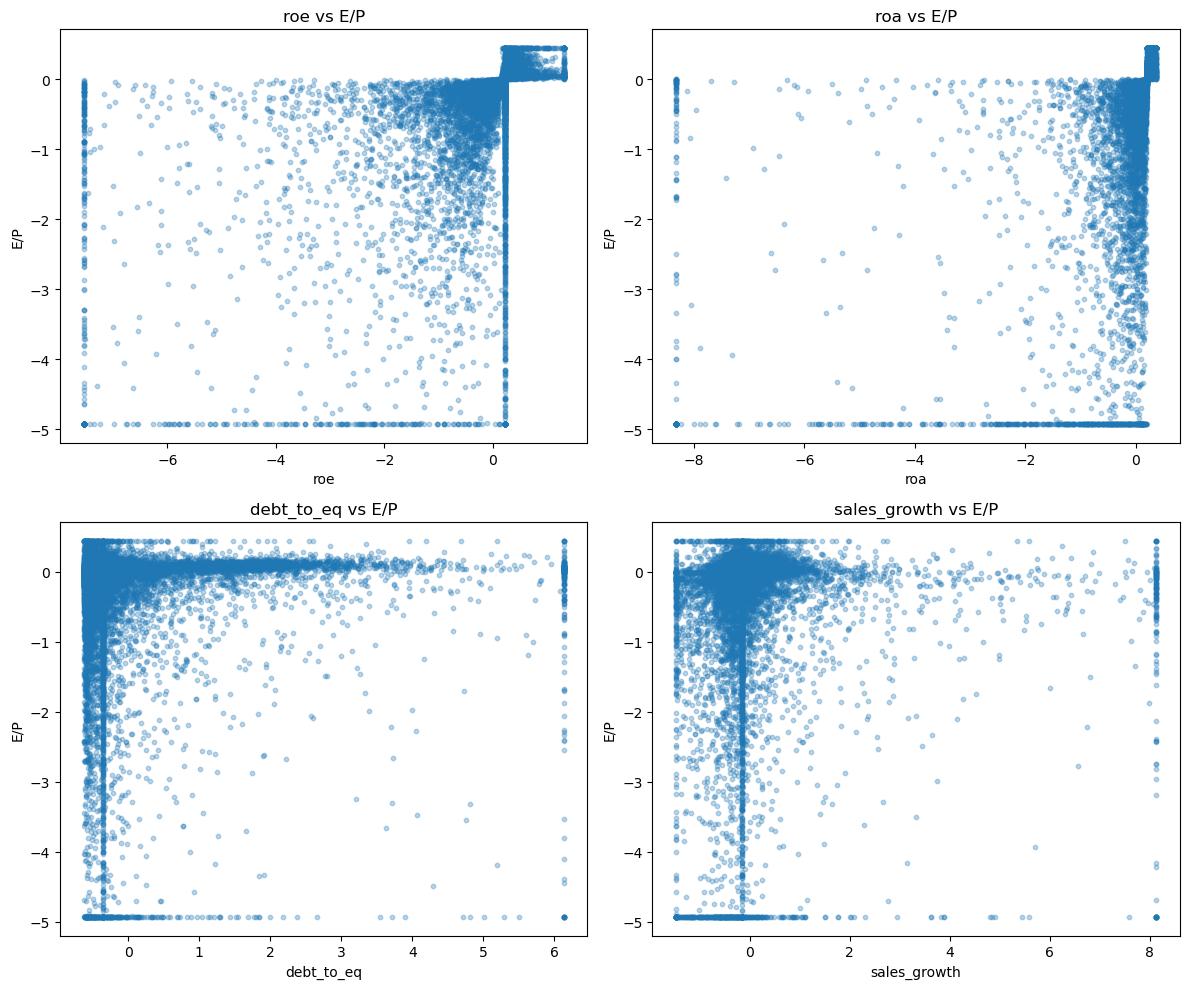

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, feature in enumerate(features):
    axes[idx].scatter(X_test[feature], Y_test, alpha=0.3, s=10)
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('E/P')
    axes[idx].set_title(f'{feature} vs E/P')

plt.tight_layout()
plt.show()

## Feature Correlation Matrix
The correlation heatmap visualizes the pairwise linear relationships among the five variables used in the model: ROE, ROA, Debt-to-Equity Ratio, Sales Growth, and the E/P ratio. Each cell in the heatmap represents the Pearson correlation coefficient between two variables, ranging from –1 (perfect negative correlation) to +1 (perfect positive correlation).

### Observations and Implications:
The heatmap reveals that while profitability variables (ROE, ROA) are meaningfully related to valuation (E/P), leverage and growth measures are weakly linked. Furthermore, the modest correlations suggest that the true relationship between financial fundamentals and valuation may be nonlinear or interaction-based, which a simple linear model cannot fully capture.

### Next steps are similar to previous ones:
- Feature engineering: Construct new features that better capture firm performance and valuation drivers
- Nonlinear Modeling Approaches

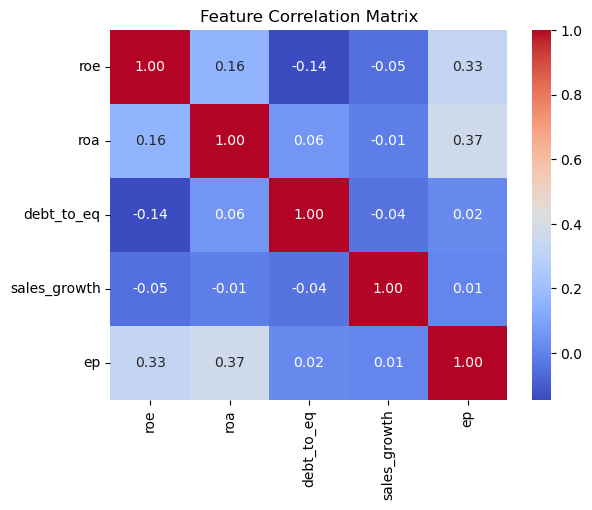

In [8]:
corr = train_data[['roe','roa','debt_to_eq','sales_growth','ep']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()


## Feature-Target Correlation
This output is the numerical correlation of each feature with the target variable (E/P). To quantify the linear relationship between each explanatory variable and the target variable (E/P ratio), a Pearson correlation analysis was performed using all numerical features in the dataset (ignore gvkey, non-related identifier). 

Same observation as the previous plots: E/P is only moderately correlated with traditional profitability measures and largely uncorrelated with leverage or growth, at least in the linear sense. 

### Implications:
- The relationship between firm fundamentals and valuation may be nonlinear or influenced by interactions not captured by simple regression.

- Or the feature set is incomplete.

Next steps remain the same as previous ones.

In [9]:
corr = train_data.select_dtypes(include=['number']).corr()['ep'].sort_values(ascending=False)
print(corr)


ep              1.000000
roa             0.366554
roe             0.325526
debt_to_eq      0.024467
sales_growth    0.009055
gvkey          -0.089729
Name: ep, dtype: float64


## Quantitative Metrics – Observations and Discussion

To evaluate the performance of the linear regression model predicting E/P ratios, three standard metrics were computed: Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and Coefficient of Determination (R^2).

1. Mean Absolute Error (MAE): \
MAE measures the average magnitude of prediction errors, ignoring their direction.
- Ideal value: Close to 0, indicating predictions are very close to actual values.
- Observation: MAE is moderate on both train and test sets. Indicates that, on average, predictions deviate from actual E/P by a meaningful amount, consistent with earlier visualizations showing the model “collapsing” predictions near zero.

2. Root Mean Squared Error (RMSE): \
RMSE measures the square root of the average squared prediction errors, penalizing larger errors more heavily.
- Ideal value: Close to 0. Lower RMSE indicates fewer large deviations.
- Observation: RMSE is higher than MAE, reflecting the presence of large residuals, particularly for firms with extreme negative E/P values. This confirms visual findings from the residual and histogram plots: the model struggles with outliers and extreme cases.

3. Coefficient of Determination (R^2): \
R^2 quantifies the proportion of variance in the target variable explained by the model.
- Ideal value: 1.0 (perfect fit), 0 indicates the model performs no better than predicting the mean, negative values indicate worse-than-mean predictions.
- Observation: R^2 is low on both train and test sets (26% of the cases explained by current features), indicating that the linear model explains only a small fraction of the variability in E/P ratios. Consistent with earlier observations, the model captures the average trend but fails to account for firm-specific or extreme values. 


MAE on train: 0.230
MAE on test: 0.375
RMSE on train: 0.583
RMSE on test: 0.886
R^2 on train: 0.210
R^2 on test: 0.260


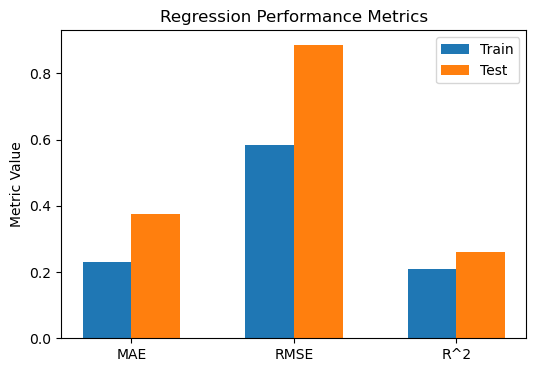

In [12]:

#MAE on data
MAETrain = mean_absolute_error(Y_train, Y_pred_train)
MAETest = mean_absolute_error(Y_test, Y_pred_test)


print(f"MAE on train: {MAETrain:.3f}")
print(f"MAE on test: {MAETest:.3f}")

#RMSE on data
RMSETrain = np.sqrt(mean_squared_error(Y_train, Y_pred_train))
RMSETest = np.sqrt(mean_squared_error(Y_test, Y_pred_test))

print(f"RMSE on train: {RMSETrain:.3f}")
print(f"RMSE on test: {RMSETest:.3f}")

#R^2 on data

RTrain = r2_score(Y_train, Y_pred_train)
RTest = r2_score(Y_test, Y_pred_test)

print(f"R^2 on train: {RTrain:.3f}")
print(f"R^2 on test: {RTest:.3f}")


metrics = ['MAE', 'RMSE', 'R^2']
train_values = [MAETrain, RMSETrain, RTrain]
test_values = [MAETest, RMSETest, RTest]

x = range(len(metrics))

plt.figure(figsize=(6,4))
plt.bar([i-0.15 for i in x], train_values, width=0.3, label='Train')
plt.bar([i+0.15 for i in x], test_values, width=0.3, label='Test')
plt.xticks(x, metrics)
plt.ylabel('Metric Value')
plt.title('Regression Performance Metrics')
plt.legend()
plt.show()



This plot shows MAE and RMSE are both higher on the test set, meaning the model makes larger prediction errors (but not by too much) on unseen data. The difference in RMSE between the training and test sets is larger than the difference in MAE, indicating that the model’s errors increase disproportionately for certain observations. Since RMSE penalizes larger errors more heavily, this suggests the model struggles with outliers or extreme E/P values, producing occasional large deviations even though average errors (MAE) remain moderate.

R² is similar (0.21 train vs 0.26 test), indicating the model explains only about 20–26% of the variance, suggesting weak predictive power overall.

Because the train and test errors are not drastically different, the model is not overfitting, but it’s also not capturing strong patterns ie it’s a relatively simple or underfit model.